# 记忆型智能体

## 回顾

我们构建了一个聊天机器人，把语义记忆保存到单一[用户档案](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)或[集合](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)中。

我们引入了 [Trustcall](https://github.com/hinthornw/trustcall) 来更新这两类模式。

## 目标

现在，我们将整合前面学到的内容，构建一个具备长期记忆的[智能体](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/)。

这个智能体叫 `task_mAIstro`，用于帮我们管理 ToDo 清单！

此前的聊天机器人会*自动*反思对话并保存记忆。

`task_mAIstro` 会自行判断 *何时* 保存记忆（即 ToDo 项目）。

此前的聊天机器人只会保存一种记忆：档案或者集合。

`task_mAIstro` 可以决定把信息写入用户档案，或写入 ToDo 项目的集合。

除了语义记忆，`task_mAIstro` 还会管理程序性记忆。

这样用户就能更新它创建 ToDo 项目的偏好。


In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os, getpass


def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")

    # Set the environment variable for the current process
    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

## 了解 Trustcall 的更新细节

Trustcall 负责创建与更新 JSON 模式。

如果我们希望了解 Trustcall 做了哪些*具体改动*，该怎么办？

例如，我们之前看到 Trustcall 自带的工具可以：

* 出现校验失败时自我纠错 —— [示例追踪](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7)
* 更新已有文档 —— [示例追踪](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

了解这些工具的行为，对我们即将构建的智能体很有帮助。

下面展示如何实现。


In [4]:
from pydantic import BaseModel, Field


class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

我们可以给 Trustcall 抽取器添加一个[监听器](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners)。

这样抽取器的运行信息就会传递给我们定义的 `Spy` 类。

`Spy` 会提取 Trustcall 所触发的工具调用信息。


In [5]:
from trustcall import create_extractor

# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi


# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )


# Initialize the spy
spy = Spy()

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen3-max", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    # tool_choice="Memory",
    tool_choice="auto",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [6]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Lance."),
    AIMessage(content="Nice to meet you, Lance."),
    HumanMessage(content="This morning I had a nice bike ride in San Francisco."),
]

# Invoke the extractor
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=instruction)] + conversation}
)

In [7]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_f4c461236287499eba7e4634)
 Call ID: call_f4c461236287499eba7e4634
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [8]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]:
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [9]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_f4c461236287499eba7e4634'}


In [10]:
# Update the conversation
updated_conversation = [
    AIMessage(content="That's great, did you do after?"),
    HumanMessage(content="I went to Tartine and ate a croissant."),
    AIMessage(content="What else is on your mind?"),
    HumanMessage(content="I was thinking about my Japan, and going back this winter!"),
]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = (
    [
        (str(i), tool_name, memory.model_dump())
        for i, memory in enumerate(result["responses"])
    ]
    if result["responses"]
    else None
)
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [11]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke(
    # {"messages": updated_conversation, "existing": existing_memories}
    {"messages": updated_conversation},
    {"existing": existing_memories},
)

In [12]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_248ae003d44c4e3dbda77b8f'}


In [13]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_248ae003d44c4e3dbda77b8f)
 Call ID: call_248ae003d44c4e3dbda77b8f
  Args:
    content: User is planning to return to Japan this winter.


In [14]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User is planning to return to Japan this winter.'


In [15]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'Memory',
   'args': {'content': 'User is planning to return to Japan this winter.'},
   'id': 'call_248ae003d44c4e3dbda77b8f',
   'type': 'tool_call'}]]

In [16]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.

    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []

    for call_group in tool_calls:
        for call in call_group:
            if call["name"] == "PatchDoc":
                changes.append(
                    {
                        "type": "update",
                        "doc_id": call["args"]["json_doc_id"],
                        "planned_edits": call["args"]["planned_edits"],
                        "value": call["args"]["patches"][0]["value"],
                    }
                )
            elif call["name"] == schema_name:
                changes.append({"type": "new", "value": call["args"]})

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change["type"] == "update":
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n" f"Content: {change['value']}"
            )

    return "\n\n".join(result_parts)


# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New Memory created:
Content: {'content': 'User is planning to return to Japan this winter.'}


## 构建智能体

有许多不同的[智能体](https://langchain-ai.github.io/langgraph/concepts/high_level/)架构可选。

这里我们实现一个简单的 [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) 智能体。

它将成为创建与管理 ToDo 清单的贴心助手。

这个智能体会根据需要更新三类长期记忆：

(a) 创建或更新包含通用用户信息的 `profile`

(b) 在 ToDo `collection` 中新增或修改条目

(c) 更新自身用于创建 ToDo 项的 `instructions`


In [ ]:
from typing import TypedDict, Literal


# Update memory tool
# 三种更新情况：user, todo, instructions
class UpdateMemory(TypedDict):
    """Decision on what memory type to update"""

    update_type: Literal["user", "todo", "instructions"]

In [18]:
# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

## 图定义

我们添加一个简单的路由器 `route_message`，用于二选一地决定是否保存记忆。

集合的更新依旧由 `write_memory` 节点里的 Trustcall 负责。


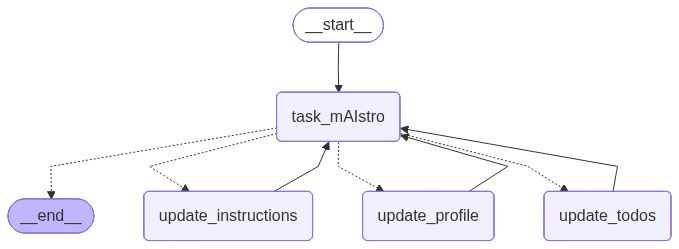

In [ ]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen3-max", temperature=0)


# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""

    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list,
    )
    interests: list[str] = Field(
        description="Interests that the user has", default_factory=list
    )


# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(
        description="Estimated time to complete the task (minutes)."
    )
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None,
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list,
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task", default="not started"
    )


# Create the Trustcall extractor for updating the user profile
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    # tool_choice="Profile",
    tool_choice="auto",
)

# Chatbot instruction for choosing what to update and what tools to call
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""


# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # 检索三种memory： user profile, todo list, instructions
    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""

    system_msg = MODEL_SYSTEM_MESSAGE.format(
        user_profile=user_profile, todo=todo, instructions=instructions
    )

    # Respond using memory as well as the chat history
    # 决定是否调用UpdateMemory工具以及调用哪一个（profile/todo/instruction）
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    return {"messages": [response]}


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(
        time=datetime.now().isoformat()
    )
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)]
            + state["messages"][:-1]
        )
    )

    # Invoke the extractor
    result = profile_extractor.invoke(
        # {"messages": updated_messages, "existing": existing_memories}
        {"messages": updated_messages},
        {"existing": existing_memories},
    )

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )
    tool_calls = state["messages"][-1].tool_calls

    ##################### important #####################
    # 向agent返回工具消息，表示原始工具调用已完成
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated profile",
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }
    ####################################################


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED = TRUSTCALL_INSTRUCTION.format(
        time=datetime.now().isoformat()
    )
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)]
            + state["messages"][:-1]
        )
    )

    ############### diffrent from `update_profile` ###############
    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()

    # Create the Trustcall extractor for updating the ToDo list
    todo_extractor = create_extractor(
        model,
        tools=[ToDo],
        # tool_choice=tool_name,
        tool_choice="auto",
        enable_inserts=True,
    ).with_listeners(on_end=spy)
    ##############################################################

    # Invoke the extractor
    result = todo_extractor.invoke(
        # {"messages": updated_messages, "existing": existing_memories}
        {"messages": updated_messages},
        {"existing": existing_memories},
    )

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )

    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state["messages"][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {
        "messages": [
            {
                "role": "tool",
                "content": todo_update_msg,
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }


def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(
        current_instructions=existing_memory.value if existing_memory else None
    )

    ####################### diffrent from `update_profile` #######################
    ####################### diffrent from `update_todo` #######################
    new_memory = model.invoke(
        [SystemMessage(content=system_msg)]
        + state["messages"][:-1]
        + [
            HumanMessage(
                content="Please update the instructions based on the conversation"
            )
        ]
    )

    # Overwrite the existing memory in the store
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    ######################################################
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated instructions",
                "tool_call_id": tool_calls[0]["id"],
            }
        ]
    }


# Conditional edge
def route_message(
    state: MessagesState, config: RunnableConfig, store: BaseStore
) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    """
    1. 检查是否有tool call
    2. 如果有，根据update_type决定调用哪个更新函数
    3. 如果没有，返回END
    """
    message = state["messages"][-1]
    if len(message.tool_calls) == 0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call["args"]["update_type"] == "user":
            return "update_profile"
        elif tool_call["args"]["update_type"] == "todo":
            return "update_todos"
        elif tool_call["args"]["update_type"] == "instructions":
            return "update_instructions"
        else:
            raise ValueError


# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [
    HumanMessage(
        content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter."
    )
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_afb8ecfc47de4ee0828b379f)
 Call ID: call_afb8ecfc47de4ee0828b379f
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! It sounds like you have a wonderful family. Let me know if there's anything specific you'd like to keep track of or if you need help with anything!


In [21]:
# User input for a ToDo
input_messages = [
    HumanMessage(content="My wife asked me to book swim lessons for the baby.")
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_dcc53b0c49984558a200503b)
 Call ID: call_dcc53b0c49984558a200503b
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for 1-year-old daughter', 'time_to_complete': '30', 'deadline': '2025-10-13T22:33:57.369364', 'status': 'not started', 'solutions': ['Search for local swim schools in San Francisco that offer infant/toddler swim classes (e.g., Aqua-Tots, Goldfish Swim School, or YMCA)', 'Check class availability and schedules', 'Read reviews or ask for recommendations from local parenting groups', 'Contact the selected swim school to enroll your daughter']}
================================== Ai Message ============================

In [22]:
# User input to update instructions for creating ToDos
input_messages = [
    HumanMessage(
        content="When creating or updating ToDo items, include specific local businesses / vendors."
    )
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_6b898203e8b44873be51628e)
 Call ID: call_6b898203e8b44873be51628e
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include specific local businesses and vendors in San Francisco when creating or updating your ToDo items. Let me know if there's anything else you'd like me to keep in mind!


In [23]:
# Check for updated instructions
user_id = "Lance"

# Search
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': '<current_instructions>\nWhen creating or updating ToDo list items, include specific local businesses or vendors relevant to the task, especially those in San Francisco. For example, when booking swim lessons for a baby, suggest actual local options such as Aqua-Tots, Goldfish Swim School, or the YMCA in SF. Always aim to provide actionable, location-specific recommendations to support task completion.\n</current_instructions>'}


In [24]:
# User input for a ToDo
input_messages = [
    HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_272d55908463432395f73904)
 Call ID: call_272d55908463432395f73904
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': '45', 'deadline': '2025-10-06T22:34:18.567208', 'status': 'not started', 'solutions': ['Contact Yale Lock Support (1-800-628-5325) for troubleshooting guidance specific to your model', 'Schedule a service appointment with a local San Francisco locksmith experienced with smart locks (e.g., San Francisco Locksmith Service, Bay Area Locksmith, or Pop-A-Lock SF)', 'Check if the issue is battery-related by replacing batteries with fresh ones', 'Consult the Yale loc

In [25]:
# Namespace for the memory to save
user_id = "Lance"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for 1-year-old daughter', 'time_to_complete': 30, 'deadline': '2025-10-13T22:33:57.369364', 'solutions': ['Search for local swim schools in San Francisco that offer infant/toddler swim classes (e.g., Aqua-Tots, Goldfish Swim School, or YMCA)', 'Check class availability and schedules', 'Read reviews or ask for recommendations from local parenting groups', 'Contact the selected swim school to enroll your daughter'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 45, 'deadline': '2025-10-06T22:34:18.567208', 'solutions': ['Contact Yale Lock Support (1-800-628-5325) for troubleshooting guidance specific to your model', 'Schedule a service appointment with a local San Francisco locksmith experienced with smart locks (e.g., San Francisco Locksmith Service, Bay Area Locksmith, or Pop-A-Lock SF)', 'Check if the issue is battery-related by replacing batteries with fresh ones', 'Consult the Yale lock manual or ap

In [26]:
# User input to update an existing ToDo
input_messages = [
    HumanMessage(
        content="For the swim lessons, I need to get that done by end of November."
    )
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_43ef9394b5e04c84837be3bc)
 Call ID: call_43ef9394b5e04c84837be3bc
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for 1-year-old daughter', 'time_to_complete': '30', 'deadline': '2025-11-30T23:59:59', 'status': 'not started', 'solutions': ['Search for local swim schools in San Francisco that offer infant/toddler swim classes (e.g., Aqua-Tots San Francisco, Goldfish Swim School – San Francisco, or YMCA locations like Chinatown YMCA or Mission Bay YMCA)', 'Check class availability and schedules for sessions starting before end of November', 'Read reviews or ask for recommendations from local parenting groups like 

可以看到 Trustcall 对已有记忆执行了补丁更新：

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r


In [27]:
# User input for a ToDo
input_messages = [
    HumanMessage(content="Need to call back City Toyota to schedule car service.")
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_64b069cee49345238254a58d)
 Call ID: call_64b069cee49345238254a58d
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back City Toyota to schedule car service', 'time_to_complete': '15', 'deadline': '2025-10-06T22:34:49.562801', 'status': 'not started', 'solutions': ['Call City Toyota Service Department directly at (415) 555-1234 (main number—confirm exact line for service scheduling)', 'Use the Toyota Owners portal or app to schedule service online if preferred', 'Have your VIN and preferred service date ready when calling', 'Ask about wait times and whether they offer loaner vehicles or shuttle service']}
================================

In [28]:
# Namespace for the memory to save
user_id = "Lance"

# Search
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for 1-year-old daughter', 'time_to_complete': 30, 'deadline': '2025-10-13T22:33:57.369364', 'solutions': ['Search for local swim schools in San Francisco that offer infant/toddler swim classes (e.g., Aqua-Tots, Goldfish Swim School, or YMCA)', 'Check class availability and schedules', 'Read reviews or ask for recommendations from local parenting groups', 'Contact the selected swim school to enroll your daughter'], 'status': 'not started'}
{'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 45, 'deadline': '2025-10-06T22:34:18.567208', 'solutions': ['Contact Yale Lock Support (1-800-628-5325) for troubleshooting guidance specific to your model', 'Schedule a service appointment with a local San Francisco locksmith experienced with smart locks (e.g., San Francisco Locksmith Service, Bay Area Locksmith, or Pop-A-Lock SF)', 'Check if the issue is battery-related by replacing batteries with fresh ones', 'Consult the Yale lock manual or ap

现在我们可以创建一个新线程。

这就相当于开启一个全新会话。

长期记忆中保存的档案、ToDo 与指令都会被读取。


In [29]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

Based on your current ToDo list and the 30 minutes you have available, here are the tasks you can realistically complete:

1. **Call back City Toyota to schedule car service**  
   - Estimated time: 15 minutes  
   - This is well within your available time.  
   - Solutions: Call City Toyota Service Department at (415) 555-1234, use the Toyota Owners portal/app, have your VIN ready, and ask about wait times or loaner vehicles.

2. **Book swim lessons for your 1-year-old daughter**  
   - Estimated time: 30 minutes  
   - This fits exactly within your available window.  
   - Solutions: Search for local swim schools like Aqua-Tots San Francisco, Goldfish Swim School – San Francisco, or YMCA locations (Chinatown or Mission Bay), check availability, read reviews from SF Parents or N

In [30]:
# Chat with the chatbot
input_messages = [
    HumanMessage(content="Yes, give me some options to call for swim lessons.")
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are some great San Francisco swim schools that offer infant/toddler swim classes for your 1-year-old daughter:

1. **Aqua-Tots San Francisco**  
   - Website: [aquatots.com/locations/ca/san-francisco](https://www.aquatots.com/locations/ca/san-francisco)  
   - Phone: (415) 555-2345  
   - Offers classes specifically for babies as young as 6 months  

2. **Goldfish Swim School – San Francisco (Marina District)**  
   - Website: [goldfishswimschool.com/sanfrancisco](https://www.goldfishswimschool.com/sanfrancisco)  
   - Phone: (415) 555-3456  
   - Warm water pools and curriculum designed for young children  

3. **YMCA of San Francisco – Chinatown or Mission Bay Locations**  
   - Chinatown YMCA: (415) 555-4567  
   - Mission Bay YMCA: (415) 555-5678  
   - Website: [y

追踪：

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)


## 疑问

为什么不是由大模型直接选择执行的tool（update_todo/update_profile/update_instructions），而是需要中间夹一层update memory显式判断???

应该修改task_mAIstro函数？？？